# OpenAIRE Graph University Overview

This notebook fetches summary statistics per university using the [OpenAIRE Graph API](https://graph.openaire.eu/docs/apis/graph-api/). For every listed university we compare three perspectives:

- **A. Publications affiliated to the university** – filter on the OpenAIRE OpenORG identifier.
- **B. Publications collected by the main (CRIS) data source** – filter on the CRS/data source identifier.
- **C. Publications collected by the secondary repository** – filter on the repository identifier when available.

For each perspective we retrieve counts for funding/projects, data sources, and research products split into publications, datasets, software, and other research outputs. The notebook separates the data collection steps so that each can be re-run independently when debugging or iterating.


In [1]:
# install required packages (if not already installed)

!pip install pandas matplotlib openpyxl python-dotenv requests tqdm pyarrow plotly ipywidgets anywidget streamlit streamlit-plotly-events jupyter-notebook-toc


  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached jsonschema-4.25.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached jsonschema_specifications-2025.9.1-py3-none-any.whl.metadata (2.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 149.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 117.3 MB/s  0:00:00
Using cached requests-2.32.5-py3-none-any.whl (64 kB)
Using cached urllib3-2.5.0-py3-none-any.whl (129 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 125.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 52.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 96.5 M

In [1]:
import jupyter_notebook_toc.core as toc_gen

# Generate TOC from the current notebook
toc = toc_gen.generate_toc("./overview-stats.ipynb")
print(toc)

# Table of Contents

OpenAIRE Graph University Overview
    1. Imports and reused constants
    2. Parse the university reference table
    3. Helper functions for the Graph API
    4. Test for one university
    5. Collect metrics for all universities
    6. Visualise total research products per organisation
    7. Fetch data source metadata
    8. Capture data source content volumes
    Todo: Capure Data source webUrl indexability
    9. Append snapshot to parquet history
    10. Visualise data source totals
    11. Compare latest vs previous snapshot
    12. Organisation vs. datasource totals comparison
    13. Organisation vs. individual datasource breakdown
    14. Download curated OAI endpoint list
    15. Merge curated endpoints into datasource export
    16. Probe OAI-PMH endpoints and capture supported formats
    17. Visualise OAI endpoint coverage
    18. Interactive datasource dashboard


## 1. Imports and reused constants


In [44]:
%%bash
#!/usr/bin/env bash
# Only run if your require to store the data on shared storage.
# Sets up a symlink so writes to ./data go to the shared storage at
# ~/data/ori-storage/dutch-sources/data.

set -euo pipefail

SCRIPT_DIR="$(cd "$(dirname "${BASH_SOURCE[0]}")" && pwd)"
LINK_PATH="$SCRIPT_DIR/data"
TARGET="${HOME}/data/ori-storage/dutch-sources/data"

if [ ! -d "$TARGET" ]; then
  echo "Target data directory not found: $TARGET" >&2
  exit 1
fi

if [ -L "$LINK_PATH" ]; then
  CURRENT_TARGET="$(readlink "$LINK_PATH")"
  if [ "$CURRENT_TARGET" = "$TARGET" ]; then
    echo "Symlink already points to target: $LINK_PATH -> $TARGET"
    exit 0
  else
    echo "Symlink exists but points to $CURRENT_TARGET; not touching" >&2
    exit 1
  fi
fi

if [ -e "$LINK_PATH" ]; then
  echo "Path exists and is not a symlink: $LINK_PATH. Remove or move it first." >&2
  exit 1
fi

ln -s "$TARGET" "$LINK_PATH"
echo "Created symlink: $LINK_PATH -> $TARGET"

bash: line 8: BASH_SOURCE[0]: unbound variable


Symlink already points to target: /home/mvanderfee3/code/dutch-sources/data -> /home/mvanderfee3/data/ori-storage/dutch-sources/data


In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import os
import csv
import time
from copy import deepcopy
from io import StringIO
from pathlib import Path
from datetime import datetime
from typing import Any, Dict, Optional, Union

import matplotlib.pyplot as plt
import pandas as pd
import requests
from tqdm.auto import tqdm
from dotenv import load_dotenv

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda value: f"{value:,.0f}")

load_dotenv()

CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")

if not CLIENT_ID or not CLIENT_SECRET:
    raise RuntimeError(
        "Missing OpenAIRE credentials. Set CLIENT_ID and CLIENT_SECRET in the environment."
    )

BASE_URL = "https://api.openaire.eu/graph"
TOKEN_URL = "https://aai.openaire.eu/oidc/token"
API_USER_AGENT = "OpenAIRE-tools overview-stats notebook"
API_PAUSE_SECONDS = 0.1  # throttle requests a bit to stay within rate limits
TOKEN_REFRESH_BUFFER = 60  # refresh the token one minute before expiration

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)
IMG_DIR = Path("img")
IMG_DIR.mkdir(exist_ok=True)

PRODUCT_TYPE_LABELS = {
    "publication": "Publications",
    "dataset": "Research data",
    "software": "Research software",
    "other": "Other research products",
}

METRIC_ORDER = [
    "Funding / Projects",
    "Data sources",
    *PRODUCT_TYPE_LABELS.values(),
]

_access_token: Optional[str] = None
_access_token_expiry: float = 0.0

print("Setup complete.")


Setup complete.


## 2. Parse the university reference table
The raw table below mirrors the values supplied in the request. We reshape it into a structured list so that the rest of the notebook can iterate over the entries.


In [24]:
# 2. Load the NL organizations reference table
# Download the latest NL organizations baseline from the Google Sheets URL

# URL of the published Google Sheets NL organizations baseline
nl_orgs_baseline_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTDQiWDIaI1SZkPTMNCovicBhA-nQND1drXoUKvrG1O_Ga3hLDRvmQZao_TvNgmNQ/pub?output=xlsx"
# Local path to store the downloaded baseline
NL_ORGS_BASELINE_PATH = DATA_DIR / "nl_orgs_baseline.xlsx"
# Name of the sheet containing the NL organizations data
NL_ORGS_SHEET_NAME = "nl-orgs"

# Function to download the NL organizations baseline
def download_nl_orgs_baseline(url: str, dest: Path) -> Path:
    """Download the latest NL organizations baseline and store it locally."""
    # Ensure the destination directory exists
    dest.parent.mkdir(parents=True, exist_ok=True)
    if dest.exists():
        print(f"Using existing baseline file: {dest}")
        return dest
        
    print(f"Downloading baseline file from {url}")
    # Download the file
    response = requests.get(url, timeout=120)
    response.raise_for_status()
    dest.write_bytes(response.content)
    print(f"Saved baseline file to: {dest}")
    return dest

# Download the NL organizations baseline
download_nl_orgs_baseline(nl_orgs_baseline_url, NL_ORGS_BASELINE_PATH)

# Set the table path to the downloaded baseline
TABLE_PATH = NL_ORGS_BASELINE_PATH

# Load and parse the NL organizations reference table
def load_university_table(path: Union[str, Path], sheet_name: str) -> pd.DataFrame:
    """Load the NL organizations reference table and normalise empty values to blanks."""
    table_path = Path(path)
    if not table_path.exists():
        raise FileNotFoundError(f"Reference table not found: {table_path}")
    excel_suffixes = {".xlsx", ".xls"}
    if table_path.suffix.lower() in excel_suffixes:
        # Load the Excel file
        df = pd.read_excel(table_path, sheet_name=sheet_name, dtype=str, keep_default_na=False)
    else:
        # Load as a TSV/CSV file
        df = pd.read_csv(table_path, sep="	", dtype=str, keep_default_na=False)
    return df.fillna("")

# Helper function to pick the first non-empty value from a list of columns
def _pick(row: pd.Series, *columns: str) -> str:
    for column in columns:
        if column not in row:
            continue
        value = row[column]
        if isinstance(value, str):
            value = value.strip()
        if value:
            return value
    return ""

# Normalize ROR link
def normalise_ror_link(value: str) -> str:
    # Normalize ROR identifier to a full URL
    value = (value or "").strip()
    # If the value is empty after stripping, return an empty string
    if not value:
        return ""
    # If the value already starts with "http", return it as is
    if value.startswith("http"):
        return value
    # If the value starts with "ror.org", prepend "https://"
    if value.startswith("ror.org"):
        return f"https://{value}"
    # Otherwise, assume it's a ROR ID and construct the full URL
    value = value.strip().strip("/")
    # If the value is empty after stripping, return an empty string
    if not value:
        return ""
    # Return the full ROR URL
    return f"https://ror.org/{value}"

# Extract ROR ID from a value
def extract_ror_id(value: str) -> str:
    value = (value or "").strip()
    if not value:
        return ""
    if value.startswith("http"):
        value = value.rstrip("/").split("/")[-1]
    return value

# Parse university rows from the DataFrame
def parse_university_rows(df: pd.DataFrame) -> list[dict[str, Optional[str]]]:
    # Parse university rows from the DataFrame and extract relevant fields
    parsed: list[dict[str, Optional[str]]] = []
    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        # Determine the university name using multiple possible columns
        name = _pick(row, "full_name_in_English", "University", "organization_name")
        # Skip rows without a valid name
        if not name:
            continue
        
        # Extract and normalize ROR information
        ror_id = extract_ror_id(_pick(row, "ROR"))
        # Normalize ROR link
        ror_link = normalise_ror_link(_pick(row, "ROR_LINK") or ror_id)
        # If ROR link is available but ROR ID is not, extract ROR ID from the link
        if ror_link and not ror_id:
            # Extract ROR ID from the normalized ROR link
            ror_id = extract_ror_id(ror_link)

        # Construct the university entry
        entry = {
            "name": name,
            "acronym_EN": _pick(row, "acronym_EN") or None,
            "acronym_AGG": _pick(row, "acronym_AGG") or None,
            "grouping": _pick(row, "main_grouping") or None,
            "ROR": ror_id or None,
            "ROR_LINK": ror_link or None,
            "OpenAIRE_ORG_ID": _pick(row, "OpenAIRE_ORG_ID", "OpenAIRE OpenORG ID", "OpenAIRE OpenORG ID LINK", "openorg_id") or None,
            "main_datasource_id": _pick(row, "OpenAIRE Data Source ID (Main/CRIS)", "OpenAIRE Data Source ID (Main/CRIS) LINK", "main_datasource_id") or None,
            "secondary_datasource_id": _pick(row, "OpenAIRE Data Source (Secondary/Repository)", "OpenAIRE Data Source (Secondary/Repository) LINK", "secondary_datasource_id") or None,
        }
        # Special handling for OpenDOAR IDs
        if entry["main_datasource_id"] and entry["main_datasource_id"].startswith("opendoar"):
            if not entry["secondary_datasource_id"]:
                entry["secondary_datasource_id"] = entry["main_datasource_id"]
                entry["main_datasource_id"] = None
        # Append the parsed entry to the list
        parsed.append(entry)

    # Return the parsed university entries
    return parsed

# Load the NL organizations reference table and parse universities
nl_orgs_df = load_university_table(TABLE_PATH, NL_ORGS_SHEET_NAME)
# Parse universities from the loaded DataFrame
universities = parse_university_rows(nl_orgs_df)
# Display the number of parsed universities
print(f"Parsed {len(universities)} universities from the reference table (loaded from {TABLE_PATH}).")
# Convert the list of universities to a DataFrame for display
universities_df = pd.DataFrame(universities)
# Display the DataFrame of universities
universities_df


Saved baseline file to: /home/mvanderfee3/data/ori-storage/dutch-sources/nl_orgs_baseline.xlsx
Parsed 94 universities from the reference table (loaded from /home/mvanderfee3/data/ori-storage/dutch-sources/nl_orgs_baseline.xlsx).


,name,acronym_EN,acronym_AGG,grouping,ROR,ROR_LINK,OpenAIRE_ORG_ID,main_datasource_id,secondary_datasource_id
0,Data Archiving Networked Services (DANS),DANS,DANS,KNAW,008pnp284,https://ror.org/008pnp284,None,None,None
1,Hubrecht Institute for Developmental Biology a...,HUBRECHT,HUBRECHT,KNAW,023qc4a07,https://ror.org/023qc4a07,None,None,None
2,International Institute of Social History (IISH),IISH,IISH,KNAW,05dq4pp56,https://ror.org/05dq4pp56,None,None,None
3,Royal Netherlands Institute of Southeast Asian...,KITLV,KITLV,KNAW,01bdv4312,https://ror.org/01bdv4312,None,None,None
4,Royal Netherlands Academy of Arts and Sciences,KNAW,KNAW,KNAW,043c0p156,https://ror.org/043c0p156,None,None,None
5,Netherlands Institute for Neuroscience,NIN,NIN,KNAW,05csn2x06,https://ror.org/05csn2x06,None,None,None
6,Netherlands Institute of Ecology (NIOO),NIOO,NIOO,KNAW,01g25jp36,https://ror.org/01g25jp36,None,None,None
7,Westerdijk Fungal Biodiversity Institute,WESTERDIJK,WESTERDIJK,KNAW,030a5r161,https://ror.org/030a5r161,None,None,None
8,Amsterdam UMC,AUMC,AUMC,NFU,05grdyy37,https://ror.org/05grdyy37,None,None,None
9,ErasmusMC,ErasmusMC,EUR/ErasmusMC,NFU,018906e22,https://ror.org/018906e22,None,None,None


## 3. Helper functions for the Graph API
These functions wrap the REST requests and centralise filter construction per scenario. Each call prints nothing by default so we can reuse them freely in later cells.


In [25]:
# Define the different scenarios for metrics collection.
# Each scenario includes a key, label, ID field, and description.
# For each scenario, we will build appropriate filters to query the OpenAIRE Graph API.
# For example, we can collect metrics based on organization affiliation,
# main data source, or secondary repository.
# Each scenario will have its own set of filters.

SCENARIO_DEFS = [
    {
        "key": "organization",
        "label": "A. OpenORG affiliation",
        "id_field": "OpenAIRE_ORG_ID",
        "description": "Publications affiliated to the university (OpenAIRE OpenORG ID)",
    },
    {
        "key": "main_datasource",
        "label": "B. Main/CRIS data source",
        "id_field": "main_datasource_id",
        "description": "Publications collected from the main CRIS data source",
    },
    {
        "key": "secondary_datasource",
        "label": "C. Secondary repository",
        "id_field": "secondary_datasource_id",
        "description": "Publications collected from the secondary / repository data source",
    },
]

# Define filter builders for each scenario.
# Each builder function takes an entity ID and returns a dictionary of filters
# for projects, data sources, and research products.
#   - The filters are used to query the OpenAIRE Graph API for relevant metrics.

FILTER_BUILDERS = {
    "organization": lambda entity_id: {
        "projects": {"relOrganizationId": entity_id},
        "dataSources": {"relOrganizationId": entity_id},
        "researchProducts": {"relOrganizationId": entity_id},
    },
    "main_datasource": lambda entity_id: {
        "projects": {"relCollectedFromDatasourceId": entity_id},
        "dataSources": {"id": entity_id},
        "researchProducts": {"relCollectedFromDatasourceId": entity_id},
    },
    "secondary_datasource": lambda entity_id: {
        "projects": {"relCollectedFromDatasourceId": entity_id},
        "dataSources": {"id": entity_id},
        "researchProducts": {"relCollectedFromDatasourceId": entity_id},
    },
}

# Define an empty metrics dictionary for collecting results.
EMPTY_METRICS = {metric: None for metric in METRIC_ORDER}

# Obtain a cached OpenAIRE access token, refreshing it when needed.
def obtain_access_token() -> str:
    """Return a cached OpenAIRE access token, refreshing it when needed."""
    global _access_token, _access_token_expiry
    now = time.time()
    if _access_token and now < _access_token_expiry:
        return _access_token

    response = requests.post(
        TOKEN_URL,
        data={"grant_type": "client_credentials"},
        auth=(CLIENT_ID, CLIENT_SECRET),
        headers={"User-Agent": API_USER_AGENT},
        timeout=60,
    )
    response.raise_for_status()
    payload = response.json()
    token = payload.get("access_token")
    if not token:
        raise RuntimeError("OpenAIRE token response did not include an access_token.")
    expires_in = int(payload.get("expires_in", 3600))
    _access_token = token
    _access_token_expiry = now + max(expires_in - TOKEN_REFRESH_BUFFER, 0)
    return _access_token

# Invoke the OpenAIRE Graph API and return the decoded JSON payload.
def call_graph_api(path: str, params: Optional[Dict[str, Any]] = None) -> Dict[str, Any]:
    """Invoke the OpenAIRE Graph API and return the decoded JSON payload."""
    url = f"{BASE_URL}{path}"
    effective_params = dict(params or {})
    effective_params.setdefault("page", 1)
    effective_params.setdefault("pageSize", 1)

    headers = {
        "User-Agent": API_USER_AGENT,
        "Authorization": f"Bearer {obtain_access_token()}",
    }

    response = requests.get(
        url,
        params=effective_params,
        headers=headers,
        timeout=60,
    )
    response.raise_for_status()
    time.sleep(API_PAUSE_SECONDS)
    return response.json()

# Retrieve the total number of matching records for the supplied endpoint.
def fetch_num_found(path: str, params: Dict[str, Any]) -> Optional[int]:
    """Return the total number of matching records for the supplied endpoint."""
    payload = call_graph_api(path, params)
    header = payload.get("header", {})
    num_found = header.get("numFound")
    return int(num_found) if num_found is not None else None

# Build filters for the given scenario and entity ID.
def build_filters(scenario_key: str, entity_id: str) -> Dict[str, Dict[str, Any]]:
    builder = FILTER_BUILDERS[scenario_key]
    return {name: dict(filters) for name, filters in builder(entity_id).items()}


# Collect metrics for a given scenario and entity ID.
def collect_metrics(scenario_key: str, entity_id: Optional[str]) -> Dict[str, Optional[int]]:
    if not entity_id:
        return deepcopy(EMPTY_METRICS)

    filters = build_filters(scenario_key, entity_id)
    results: Dict[str, Optional[int]] = {}

    results["Funding / Projects"] = fetch_num_found("/v1/projects", filters["projects"])
    results["Data sources"] = fetch_num_found("/v1/dataSources", filters["dataSources"])

    for rp_type, label in PRODUCT_TYPE_LABELS.items():
        rp_params = dict(filters["researchProducts"], type=rp_type)
        results[label] = fetch_num_found("/v2/researchProducts", rp_params)

    return results


In [26]:
from functools import lru_cache

# Cache OpenAIRE ID lookups to avoid redundant API calls

@lru_cache(maxsize=None)
def _fetch_openorg_id(ror_url: str) -> Optional[str]:
    # Query the OpenAIRE Graph API for the organization with the given ROR URL
    try:
        payload = call_graph_api("/v1/organizations", {"pid": ror_url})
    except requests.RequestException as exc:
        print(f"Failed to fetch OpenAIRE ID for {ror_url}: {exc}")
        return None

    # Extract the OpenAIRE organization ID from the response
    results = payload.get("results") or []
    for item in results:
        openorg_id = item.get("id")
        if openorg_id:
            return openorg_id
    return None

# Look up the OpenAIRE organization identifier using a ROR ID or URL.

def fetch_openorg_id_for_ror(ror_value: Optional[str]) -> Optional[str]:
    """Look up the OpenAIRE organization identifier using a ROR ID or URL."""
    if not ror_value:
        return None
    # Normalize the ROR value to a URL
    ror_url = normalise_ror_link(ror_value)
    if not ror_url:
        return None
    # Look up the OpenAIRE organization ID using the normalized ROR URL
    return _fetch_openorg_id(ror_url)


## 4. Test for one university

Run a quick test for the first university in the list to fetch the 
  OpenORG affiliation,
  and the Number of: 
  Funding / Projects,
  Data sources, 
  Products: Total,
  Products: Publications, 
  Products: Research data, 
  Products: Research software,
  Products: Other research products

In [27]:
# Example: collect and display metrics for the first university in the list
test_university = universities[0]
print(f"Testing metrics for: {test_university['name']}")

# Determine the OpenAIRE organization identifier
identifier = test_university.get("OpenAIRE_ORG_ID")
if not identifier:
    # Try to resolve it via the ROR ID/link
    resolved = fetch_openorg_id_for_ror(test_university.get("ROR_LINK") or test_university.get("ROR"))
    identifier = resolved

# Collect and display metrics    
print(f"\nOpenAIRE ID: {identifier}")
print("\nMetrics:")
# Collect metrics for the organization
metrics = collect_metrics("organization", identifier)

# Calculate total research products
research_products_total = sum(
    metrics.get(product_type, 0) or 0 
    for product_type in ["Publications", "Research data", "Research software", "Other research products"]
)
print("Total Research Products:", research_products_total)
print("\nBreakdown by type:")

# Display the collected metrics
for metric, count in metrics.items():
    print(f"{metric}: {count}")

Testing metrics for: Data Archiving Networked Services (DANS)

OpenAIRE ID: openorgs____::a8767e80afb51d63802fdf1ddabeacb0

Metrics:
Total Research Products: 10231

Breakdown by type:
Funding / Projects: 0
Data sources: 16
Publications: 438
Research data: 9561
Research software: 99
Other research products: 133


## 5. Collect metrics for all universities
Loop through every organisation, ensure an OpenAIRE identifier is available, and add this information to new columns. and write to file nl_orgs_openaire.xlsx

In [28]:

# 5. Enrich the NL organizations table with OpenAIRE IDs and metrics

metric_columns = [
    "Data sources",
    "Total Research Products",
    "Publications",
    "Research data",
    "Research software",
    "Other research products",
]

output_path = DATA_DIR / "nl_orgs_openaire.xlsx"
checkpoint_path = DATA_DIR / "nl_orgs_openaire.tmp.xlsx"
save_every = 5  # save every N rows
max_workers = 6  # number of concurrent workers

if output_path.exists():
    enriched_df = pd.read_excel(output_path)
    for column in metric_columns:
        if column not in enriched_df.columns:
            enriched_df[column] = pd.NA
    print(f"Loaded existing enriched dataset from {output_path}")
else:
    enriched_df = universities_df.copy()
    for column in metric_columns:
        if column not in enriched_df.columns:
            enriched_df[column] = pd.NA

    def enrich_row(idx: int) -> tuple[int, dict[str, Any]]:
        row = enriched_df.loc[idx]
        identifier = row.get("OpenAIRE_ORG_ID")
        added_id = False
        if not identifier:
            identifier = fetch_openorg_id_for_ror(row.get("ROR_LINK") or row.get("ROR"))
            if identifier:
                added_id = True

        metrics = collect_metrics("organization", identifier)
        result = {"OpenAIRE_ORG_ID": identifier}

        if identifier and metrics:
            total_products = sum((metrics.get(label) or 0) for label in metric_columns[2:])
            for column in metric_columns:
                result[column] = total_products if column == "Total Research Products" else metrics.get(column)
        else:
            for column in metric_columns:
                result[column] = pd.NA

        result["added_id"] = added_id
        return idx, result

    progress = tqdm(enriched_df.index, desc="Enriching OpenAIRE IDs & metrics", unit="org")
    enriched_count = 0

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(enrich_row, idx): idx for idx in enriched_df.index}
        for processed, future in enumerate(as_completed(futures), start=1):
            idx, result = future.result()
            enriched_df.at[idx, "OpenAIRE_ORG_ID"] = result["OpenAIRE_ORG_ID"]
            for column in metric_columns:
                enriched_df.at[idx, column] = result[column]
            if result.get("added_id"):
                enriched_count += 1
            progress.update(1)
            if processed % save_every == 0:
                enriched_df.to_excel(checkpoint_path, index=False)
                progress.set_postfix(saved_rows=processed)

    progress.close()
    enriched_df.to_excel(output_path, index=False)
    print(f"Added OpenAIRE IDs for {enriched_count} organizations")
    print(f"Saved enriched data to {output_path}")
    if checkpoint_path.exists():
        print(f"Checkpoint saved to {checkpoint_path}")

enriched_df.head()

missing_ids = enriched_df[enriched_df["OpenAIRE_ORG_ID"].isna() | (enriched_df["OpenAIRE_ORG_ID"] == "")]
if not missing_ids.empty:
    print("Organizations still missing OpenAIRE IDs:")
    for name in missing_ids['name']:
        print(f"- {name}")


Enriching OpenAIRE IDs & metrics:   0%|          | 0/94 [00:00<?, ?org/s]

Added OpenAIRE IDs for 86 organizations
Saved enriched data to /home/mvanderfee3/data/ori-storage/dutch-sources/nl_orgs_openaire.xlsx
Checkpoint saved to /home/mvanderfee3/data/ori-storage/dutch-sources/nl_orgs_openaire.tmp.xlsx
Organizations still missing OpenAIRE IDs:
- UMCG
- Wetenschappelijk Onderzoek- en Documentatiecentrum
- University of Humanistic Studies
- VH (HBO Kennisbank)
- Theological University
- Jan Ingenhouszinstituut
- Nationaal Archief of the Netherlands
- Total


## 6. Visualise total research products per organisation
Convert the enriched metrics to numeric form and plot the total research products per organisation (sorted descending).

Saved organisation totals chart to img/org_total_products.png


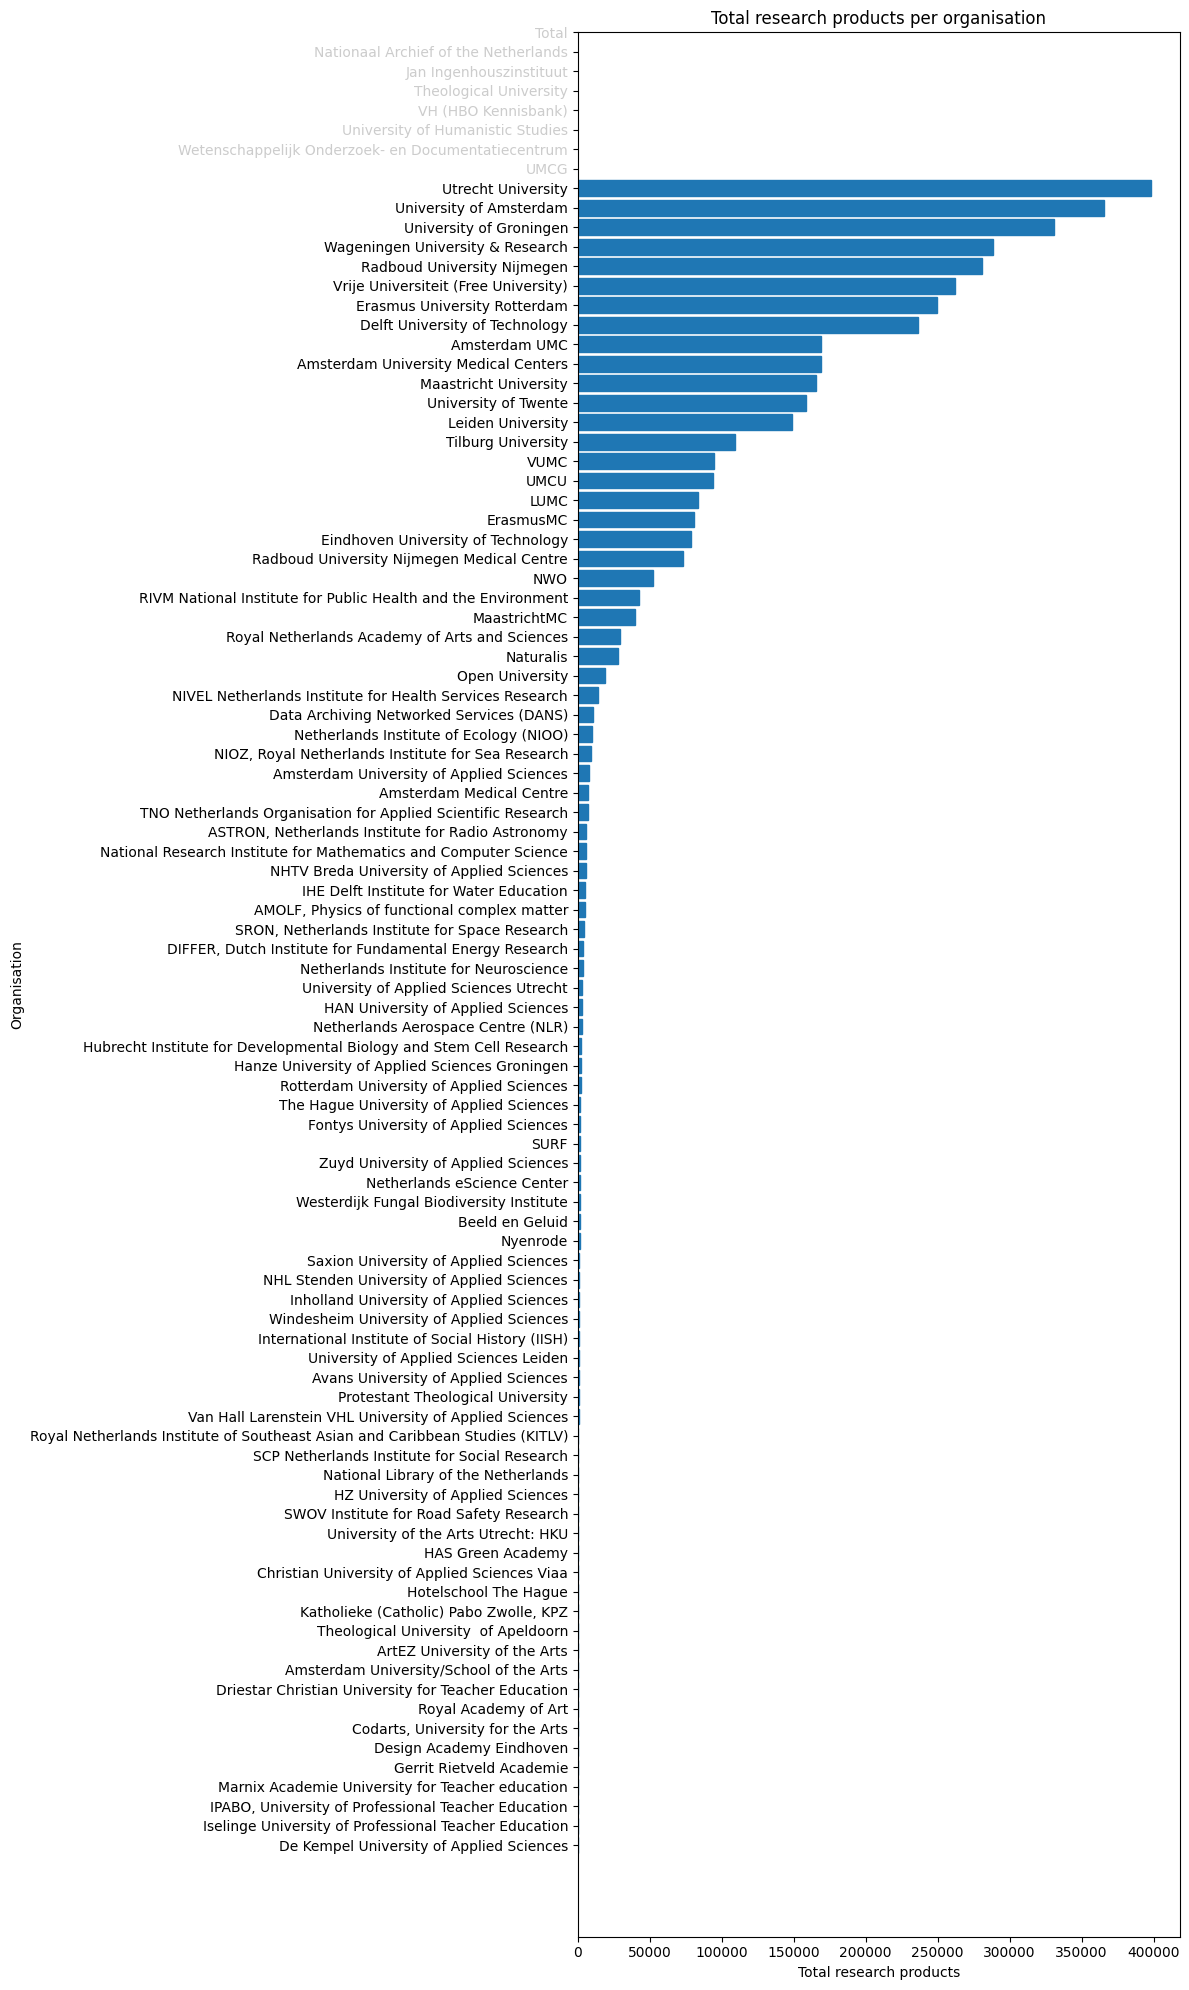

In [29]:
numeric_columns = [
    "Total Research Products",
    "Publications",
    "Research data",
    "Research software",
    "Other research products",
]

for column in numeric_columns:
    enriched_df[column] = pd.to_numeric(enriched_df[column], errors="coerce")

plot_df = enriched_df.sort_values("Total Research Products", ascending=True)

fig, ax = plt.subplots(figsize=(12, 20))
has_missing_id = plot_df["OpenAIRE_ORG_ID"].isna()
bars = ax.barh(range(len(plot_df)), plot_df["Total Research Products"])
for idx, missing in enumerate(has_missing_id):
    bars[idx].set_color("#cccccc" if missing else "#1f77b4")

ax.set_yticks(range(len(plot_df)))
ax.set_yticklabels(plot_df["name"])
for idx, label in enumerate(ax.get_yticklabels()):
    label.set_color("#cccccc" if has_missing_id.iloc[idx] else "black")

ax.set_xlabel("Total research products")
ax.set_ylabel("Organisation")
ax.set_title("Total research products per organisation")
fig.tight_layout()
org_chart_path = IMG_DIR / "org_total_products.png"
fig.savefig(org_chart_path, dpi=200, bbox_inches="tight")
print(f"Saved organisation totals chart to {org_chart_path}")
plt.show()


## 7. Fetch data source metadata
Retrieve every OpenAIRE data source linked to the enriched organisations and cache the registry details.

In [30]:

# 7. Fetch and store OpenAIRE data source metadata for NL organizations

datasource_columns = [
    "OpenAIRE_ORG_ID",
    "OpenAIRE_DataSource_ID",
    "Name",
    "Type",
    "websiteUrl",
    "OAI-endpoint",
    "supports_NL-DIDL",
    "support_OAI-DC",
    "support_OAI-openaire",
    "supports_RIOXX",
    "support_OpenAIRE-CERIF",
    "openaireCompatibility",
    "Last_Indexed_Date",
    "dateOfValidation",
]

datasources_path = DATA_DIR / "nl_orgs_openaire_datasources.xlsx"

if datasources_path.exists():
    datasources_df = pd.read_excel(datasources_path)
    print(f"Loaded existing datasource metadata from {datasources_path}")
else:
    def _parse_datasource_record(org_id: Optional[str], item: Dict[str, Any]) -> dict[str, Any]:
        name = item.get("officialName") or item.get("englishName")
        ds_type = (item.get("type") or {}).get("value")
        return {
            "OpenAIRE_ORG_ID": org_id,
            "OpenAIRE_DataSource_ID": item.get("id"),
            "Name": name,
            "Type": ds_type,
            "websiteUrl": item.get("websiteUrl"),
            "OAI-endpoint": None,
            "supports_NL-DIDL": None,
            "support_OAI-DC": None,
            "support_OAI-openaire": None,
            "supports_RIOXX": None,
            "support_OpenAIRE-CERIF": None,
            "openaireCompatibility": item.get("openaireCompatibility"),
            "Last_Indexed_Date": item.get("lastIndexedDate") or item.get("lastIndexDate"),
            "dateOfValidation": item.get("dateOfValidation"),
        }

    def fetch_datasources_for_org(org_entry: dict[str, Any]) -> list[dict[str, Any]]:
        org_id = org_entry.get("OpenAIRE_ORG_ID")
        if not org_id:
            return []
        records: list[dict[str, Any]] = []
        page = 1
        page_size = 100
        while True:
            payload = call_graph_api(
                "/v1/dataSources",
                {
                    "relOrganizationId": org_id,
                    "page": page,
                    "pageSize": page_size,
                },
            )
            results = payload.get("results") or []
            for item in results:
                records.append(_parse_datasource_record(org_id, item))
            header = payload.get("header") or {}
            num_found = header.get("numFound", 0)
            if page * page_size >= num_found or not results:
                break
            page += 1
        return records

    datasource_records: list[dict[str, Any]] = []
    org_entries = enriched_df.to_dict("records")
    with ThreadPoolExecutor(max_workers=6) as executor:
        futures = {executor.submit(fetch_datasources_for_org, entry): entry for entry in org_entries}
        for future in tqdm(
            as_completed(futures),
            total=len(org_entries),
            desc="Fetching data sources",
            unit="org",
        ):
            datasource_records.extend(future.result())

    datasources_df = pd.DataFrame(datasource_records, columns=datasource_columns)
    datasources_df.to_excel(datasources_path, index=False)
    print(f"Saved {len(datasources_df)} data source rows to {datasources_path}")

datasources_df.head()


Fetching data sources:   0%|          | 0/94 [00:00<?, ?org/s]

Saved 170 data source rows to /home/mvanderfee3/data/ori-storage/dutch-sources/nl_orgs_openaire_datasources.xlsx


,OpenAIRE_ORG_ID,OpenAIRE_DataSource_ID,Name,Type,websiteUrl,OAI-endpoint,supports_NL-DIDL,support_OAI-DC,support_OAI-openaire,supports_RIOXX,support_OpenAIRE-CERIF,openaireCompatibility,Last_Indexed_Date,dateOfValidation
0,openorgs____::cb77737b5a390319030e6abdb12aa6ad,opendoar____::97275a23ca44226c9964043c8462be96,KNAW Repository,Institutional Repository,http://pure.knaw.nl/portal/,None,None,None,None,None,None,collected from a compatible aggregator,None,None
1,openorgs____::cb77737b5a390319030e6abdb12aa6ad,re3data_____::c4493890b3fefddfe9408389ff121d43,DANS Data Station Physical and Technical Sciences,Data Repository,https://phys-techsciences.datastations.nl/,None,None,None,None,None,None,Not yet registered,None,None
2,openorgs____::cb77737b5a390319030e6abdb12aa6ad,re3data_____::10d900a394f89a7148e1ae18b7b66aa0,Huygens ING,Data Repository,https://www.huygens.knaw.nl/?lang=en,None,None,None,None,None,None,Not yet registered,None,None
3,openorgs____::cb77737b5a390319030e6abdb12aa6ad,re3data_____::84e123776089ce3c7a33db98d9cd15a8,EASY,Data Repository,https://easy.dans.knaw.nl/ui/home,None,None,None,None,None,None,Not yet registered,None,2015-01-14
4,openorgs____::a8369fe646a573e841439d2c24396b49,opendoar____::fe70c36866add1572a8e2b96bfede7bf,Repository ISS and Hivos,Institutional Repository,http://ir.iss.nl/,None,None,None,None,None,None,Not yet registered,None,None


## 8. Capture data source content volumes
Collect fresh numFound counts per data source (total and by product type) and store the snapshot with today's date.

In [31]:

# 8. Collect and store numFound snapshots for data sources

snapshot_date = datetime.utcnow().date().isoformat()
snapshot_path = DATA_DIR / f"nl_orgs_openaire_datasources_numFound_{snapshot_date}.xlsx"

if snapshot_path.exists():
    datasource_metrics_df = pd.read_excel(snapshot_path)
    print(f"Loaded existing numFound snapshot for {snapshot_date} from {snapshot_path}")
elif datasources_df.empty:
    print("No data sources available; skipping numFound snapshot.")
    datasource_metrics_df = pd.DataFrame(
        columns=[
            "OpenAIRE_DataSource_ID",
            "Name",
            "Total Research Products",
            *PRODUCT_TYPE_LABELS.values(),
            "date_retrieved",
        ]
    )
else:
    def collect_datasource_counts(row: pd.Series) -> dict[str, Any]:
        datasource_id = getattr(row, "OpenAIRE_DataSource_ID", None)
        if not datasource_id:
            return {}
        metrics: dict[str, Any] = {
            "OpenAIRE_DataSource_ID": datasource_id,
            "Name": getattr(row, "Name", None),
            "date_retrieved": snapshot_date,
        }
        total_params = {"relCollectedFromDatasourceId": datasource_id}
        metrics["Total Research Products"] = fetch_num_found(
            "/v2/researchProducts", total_params
        )
        for rp_type, label in PRODUCT_TYPE_LABELS.items():
            rp_params = {"relCollectedFromDatasourceId": datasource_id, "type": rp_type}
            metrics[label] = fetch_num_found("/v2/researchProducts", rp_params)
        return metrics

    datasource_metrics: list[dict[str, Any]] = []
    with ThreadPoolExecutor(max_workers=6) as executor:
        futures = {
            executor.submit(collect_datasource_counts, row): row
            for row in datasources_df.itertuples(index=False)
        }
        for future in tqdm(
            as_completed(futures),
            total=len(futures),
            desc="Collecting numFound",
            unit="datasource",
        ):
            result = future.result()
            if result:
                datasource_metrics.append(result)

    datasource_metrics_df = pd.DataFrame(
        datasource_metrics,
        columns=[
            "OpenAIRE_DataSource_ID",
            "Name",
            "Total Research Products",
            *PRODUCT_TYPE_LABELS.values(),
            "date_retrieved",
        ],
    )

    datasource_metrics_df.to_excel(snapshot_path, index=False)
    print(
        f"Saved snapshot with {len(datasource_metrics_df)} data sources to {snapshot_path}"
    )

datasource_metrics_df.head()


Saved snapshot with 170 data sources to /home/mvanderfee3/data/ori-storage/dutch-sources/nl_orgs_openaire_datasources_numFound_2025-11-27.xlsx


,OpenAIRE_DataSource_ID,Name,Total Research Products,Publications,Research data,Research software,Other research products,date_retrieved
0,opendoar____::fe70c36866add1572a8e2b96bfede7bf,Repository ISS and Hivos,0,0,0,0,0,2025-11-27
1,re3data_____::c4493890b3fefddfe9408389ff121d43,DANS Data Station Physical and Technical Sciences,0,0,0,0,0,2025-11-27
2,re3data_____::84e123776089ce3c7a33db98d9cd15a8,EASY,0,0,0,0,0,2025-11-27
3,re3data_____::10d900a394f89a7148e1ae18b7b66aa0,Huygens ING,0,0,0,0,0,2025-11-27
4,opendoar____::97275a23ca44226c9964043c8462be96,KNAW Repository,0,0,0,0,0,2025-11-27


## Todo: Capure Data source webUrl indexability

in this part we follow to webURL to check: 

1. is it available (incl HTTPS status code), 
2. if it contains a robots.txt (and its content) 
3. it robots.txt allows crawlers to index the website. 
4. if sitemap.xml is present. 
5. if HTML pages of articles contain HTML meta-tags. 
6. if meta-tags follow the [Google Scholar indexing Guidelines](https://scholar.google.com/intl/en/scholar/inclusion.html#indexing)

## 9. Append snapshot to parquet history
Keep a cumulative parquet log so repeated snapshots form a time series.

In [32]:

# 9. Append snapshot to historical log

history_path = DATA_DIR / "nl_orgs_openaire_datasources_numFound_history.xlsx"
history_columns = [
    "OpenAIRE_DataSource_ID",
    "Name",
    "Total Research Products",
    *PRODUCT_TYPE_LABELS.values(),
    "date_retrieved",
]

if history_path.exists():
    historical_df = pd.read_excel(history_path)
    print(f"Loaded historical log from {history_path}")
else:
    historical_df = pd.DataFrame(columns=history_columns)
    print("No historical log found; a new one will be created if data is appended.")

if datasource_metrics_df.empty:
    print("No snapshot data to append.")
else:
    snapshot_date_value = None
    if "date_retrieved" in datasource_metrics_df.columns and not datasource_metrics_df["date_retrieved"].isna().all():
        snapshot_date_value = str(datasource_metrics_df["date_retrieved"].iloc[0])

    already_recorded = (
        snapshot_date_value is not None
        and not historical_df.empty
        and "date_retrieved" in historical_df.columns
        and snapshot_date_value in historical_df["date_retrieved"].astype(str).values
    )

    if already_recorded:
        print(f"Snapshot for {snapshot_date_value} already recorded; skipping append.")
    else:
        combined_df = (
            pd.concat([historical_df, datasource_metrics_df], ignore_index=True)
            if not historical_df.empty
            else datasource_metrics_df.copy()
        )
        for column in [
            "Total Research Products",
            *PRODUCT_TYPE_LABELS.values(),
        ]:
            if column in combined_df.columns:
                combined_df[column] = pd.to_numeric(combined_df[column], errors="coerce")

        combined_df.to_excel(history_path, index=False)
        historical_df = combined_df
        print(
            f"History now contains {len(historical_df)} rows at {history_path}"
        )


No historical log found; a new one will be created if data is appended.
History now contains 170 rows at /home/mvanderfee3/data/ori-storage/dutch-sources/nl_orgs_openaire_datasources_numFound_history.xlsx


## 10. Visualise data source totals
Bar chart of the latest total research products per data source.

Datasources with zero total research products (excluded from chart):
 - Repository ISS and Hivos (opendoar____::fe70c36866add1572a8e2b96bfede7bf)
 - DANS Data Station Physical and Technical Sciences (re3data_____::c4493890b3fefddfe9408389ff121d43)
 - DANS Data Station Physical and Technical Sciences (re3data_____::c4493890b3fefddfe9408389ff121d43)
 - EASY (re3data_____::84e123776089ce3c7a33db98d9cd15a8)
 - EASY (re3data_____::84e123776089ce3c7a33db98d9cd15a8)
 - Huygens ING (re3data_____::10d900a394f89a7148e1ae18b7b66aa0)
 - Huygens ING (re3data_____::10d900a394f89a7148e1ae18b7b66aa0)
 - KNAW Repository (opendoar____::97275a23ca44226c9964043c8462be96)
 - IISH Dataverse (re3data_____::f134a3812781f724f5cd4292cdc7b31f)
 - DANS Data Station Physical and Technical Sciences (re3data_____::c4493890b3fefddfe9408389ff121d43)
 - DANS Data Station Physical and Technical Sciences (re3data_____::c4493890b3fefddfe9408389ff121d43)
 - DANS Data Station Archaeology (fairsharing_::56c3b2c6ea3a83aaeeff3

/tmp/ipykernel_2327/4063839271.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(len(unique_types), 1))


Saved latest data source totals chart to img/datasource_totals_latest.png


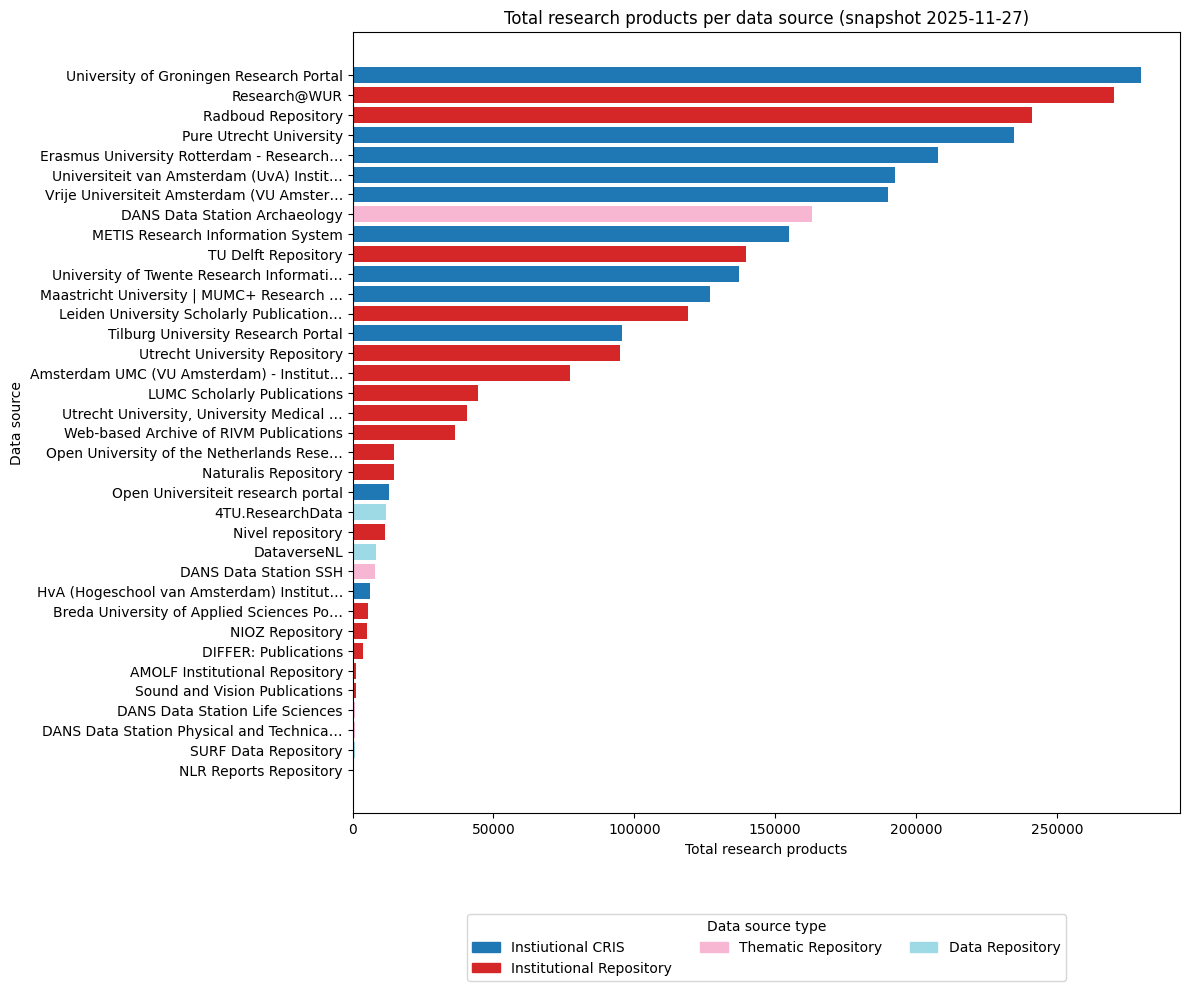

In [33]:
history_path = DATA_DIR / "nl_orgs_openaire_datasources_numFound_history.xlsx"
datasources_path = DATA_DIR / "nl_orgs_openaire_datasources.xlsx"
if not history_path.exists():
    print(f"History file {history_path} not found.")
else:
    history_df = pd.read_excel(history_path)
    numeric_columns = [
        "Total Research Products",
        *PRODUCT_TYPE_LABELS.values(),
    ]
    for column in numeric_columns:
        if column in history_df.columns:
            history_df[column] = pd.to_numeric(history_df[column], errors="coerce")

    history_df["date_retrieved"] = pd.to_datetime(history_df["date_retrieved"], errors="coerce")
    latest_date = history_df["date_retrieved"].max()
    latest_df = history_df[history_df["date_retrieved"] == latest_date].copy()

    if latest_df.empty:
        print("No rows for the latest snapshot date.")
    else:
        if "Type" not in latest_df.columns or latest_df["Type"].isna().all():
            if 'datasources_df' in globals():
                type_lookup = datasources_df[["OpenAIRE_DataSource_ID", "Type"]].copy()
            elif datasources_path.exists():
                type_lookup = pd.read_excel(datasources_path)[
                    ["OpenAIRE_DataSource_ID", "Type"]
                ].copy()
            else:
                type_lookup = pd.DataFrame(columns=["OpenAIRE_DataSource_ID", "Type"])

            latest_df = latest_df.merge(
                type_lookup,
                on="OpenAIRE_DataSource_ID",
                how="left",
                suffixes=(None, "_ds"),
            )
            if "Type_ds" in latest_df.columns:
                latest_df["Type"] = latest_df["Type"].fillna(latest_df["Type_ds"])
                latest_df = latest_df.drop(columns=["Type_ds"])

        zero_mask = latest_df["Total Research Products"].fillna(0) <= 0
        zero_total_df = latest_df[zero_mask].copy()
        if not zero_total_df.empty:
            print("Datasources with zero total research products (excluded from chart):")
            for _, row in zero_total_df.iterrows():
                print(f" - {row.get('Name', 'Unknown')} ({row.get('OpenAIRE_DataSource_ID')})")

        latest_df = latest_df.loc[~zero_mask].copy()
        if latest_df.empty:
            print("All datasources reported zero totals; skipping chart.")
        else:
            latest_df = latest_df.sort_values("Total Research Products", ascending=False)
            max_label_length = 40
            display_names = (
                latest_df["Name"].fillna("Unknown")
                .astype(str)
                .apply(lambda text: text if len(text) <= max_label_length else text[: max_label_length - 1] + "…")
            )

            type_series = latest_df["Type"].fillna("Unknown")
            unique_types = type_series.unique()
            cmap = plt.cm.get_cmap("tab20", max(len(unique_types), 1))
            color_map = {t: cmap(i) for i, t in enumerate(unique_types)}
            colors = type_series.map(color_map)

            fig, ax = plt.subplots(figsize=(12, 10))
            ax.barh(display_names, latest_df["Total Research Products"], color=colors)
            ax.set_title(
                f"Total research products per data source (snapshot {latest_date.date()})"
            )
            ax.set_xlabel("Total research products")
            ax.set_ylabel("Data source")
            ax.invert_yaxis()

            handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[t]) for t in unique_types]
            ax.legend(
                handles,
                unique_types,
                title="Data source type",
                loc="upper center",
                bbox_to_anchor=(0.5, -0.12),
                ncol=3,
            )
            fig.tight_layout()
            chart_path = IMG_DIR / "datasource_totals_latest.png"
            fig.savefig(chart_path, dpi=200, bbox_inches="tight")
            print(f"Saved latest data source totals chart to {chart_path}")
            plt.show()


## 11. Compare latest vs previous snapshot
Show side-by-side totals for the latest two snapshots per data source.

In [34]:
history_path = DATA_DIR / "nl_orgs_openaire_datasources_numFound_history.xlsx"
datasources_path = DATA_DIR / "nl_orgs_openaire_datasources.xlsx"
if not history_path.exists():
    print(f"History file {history_path} not found.")
else:
    history_df = pd.read_excel(history_path)
    numeric_columns = [
        "Total Research Products",
        *PRODUCT_TYPE_LABELS.values(),
    ]
    for column in numeric_columns:
        if column in history_df.columns:
            history_df[column] = pd.to_numeric(history_df[column], errors="coerce")

    history_df["date_retrieved"] = pd.to_datetime(history_df["date_retrieved"], errors="coerce")
    unique_dates = sorted(history_df["date_retrieved"].dropna().unique())
    if len(unique_dates) < 2:
        print("Not enough snapshots to compare (need at least two dates).")
    else:
        latest_date = unique_dates[-1]
        previous_date = unique_dates[-2]
        latest_df = history_df[history_df["date_retrieved"] == latest_date].copy()
        previous_df = history_df[history_df["date_retrieved"] == previous_date].copy()

        if 'datasources_df' in globals():
            type_lookup = datasources_df[["OpenAIRE_DataSource_ID", "Type"]].copy()
        elif datasources_path.exists():
            type_lookup = pd.read_excel(datasources_path)[
                ["OpenAIRE_DataSource_ID", "Type"]
            ].copy()
        else:
            type_lookup = pd.DataFrame(columns=["OpenAIRE_DataSource_ID", "Type"])

        def attach_type(df: pd.DataFrame) -> pd.DataFrame:
            if "Type" in df.columns and df["Type"].notna().any():
                return df
            merged = df.merge(
                type_lookup,
                on="OpenAIRE_DataSource_ID",
                how="left",
                suffixes=(None, "_ds"),
            )
            if "Type_ds" in merged.columns:
                merged["Type"] = merged["Type"].fillna(merged["Type_ds"])
                merged = merged.drop(columns=["Type_ds"])
            return merged

        latest_df = attach_type(latest_df)
        previous_df = attach_type(previous_df)

        combined = latest_df[[
            "OpenAIRE_DataSource_ID",
            "Name",
            "Type",
            "Total Research Products",
        ]].rename(columns={"Total Research Products": "Total Research Products_latest"})

        combined = combined.merge(
            previous_df[["OpenAIRE_DataSource_ID", "Total Research Products"]]
            .rename(columns={"Total Research Products": "Total Research Products_previous"}),
            on="OpenAIRE_DataSource_ID",
            how="outer",
        )

        combined["Name"] = combined["Name"].fillna("Unknown")
        combined["Type"] = combined["Type"].fillna("Unknown")
        combined = combined.fillna({
            "Total Research Products_latest": 0,
            "Total Research Products_previous": 0,
        })

        zero_mask = combined["Total Research Products_latest"].fillna(0) <= 0
        zero_total_df = combined[zero_mask].copy()
        if not zero_total_df.empty:
            print("Datasources with zero total research products (excluded from comparison chart):")
            for _, row in zero_total_df.iterrows():
                print(f" - {row.get('Name', 'Unknown')} ({row.get('OpenAIRE_DataSource_ID')})")

        combined = combined.loc[~zero_mask].copy()
        if combined.empty:
            print("No datasources with non-zero totals available for comparison chart.")
        else:
            combined = combined.sort_values("Total Research Products_latest", ascending=False)
            max_label_length = 40
            display_names = (
                combined["Name"].astype(str)
                .apply(lambda text: text if len(text) <= max_label_length else text[: max_label_length - 1] + "…")
            )

            fig, ax = plt.subplots(figsize=(12, 30))
            y_positions = range(len(combined))
            bar_height = 0.35
            ax.barh(
                [y + bar_height / 2 for y in y_positions],
                combined["Total Research Products_latest"],
                height=bar_height,
                color="#1a9850",
                label=f"Latest ({latest_date.date()})",
            )
            ax.barh(
                [y - bar_height / 2 for y in y_positions],
                combined["Total Research Products_previous"],
                height=bar_height,
                color="#b8e186",
                label=f"Previous ({previous_date.date()})",
            )

            ax.set_yticks(list(y_positions))
            ax.set_yticklabels(display_names)
            ax.set_xlabel("Total research products")
            ax.set_title("Latest vs previous total research products per data source")
            ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.08), ncol=2)
            ax.invert_yaxis()
            fig.tight_layout()
            compare_path = IMG_DIR / "datasource_totals_compare.png"
            fig.savefig(compare_path, dpi=200, bbox_inches="tight")
            print(f"Saved comparison chart to {compare_path}")
            plt.show()


Not enough snapshots to compare (need at least two dates).


## 12. Organisation vs. datasource totals comparison
Compare each organisation's total research products with the combined totals of all datasources linked to it.

Saved organisation vs datasource comparison chart to img/org_vs_datasources.png


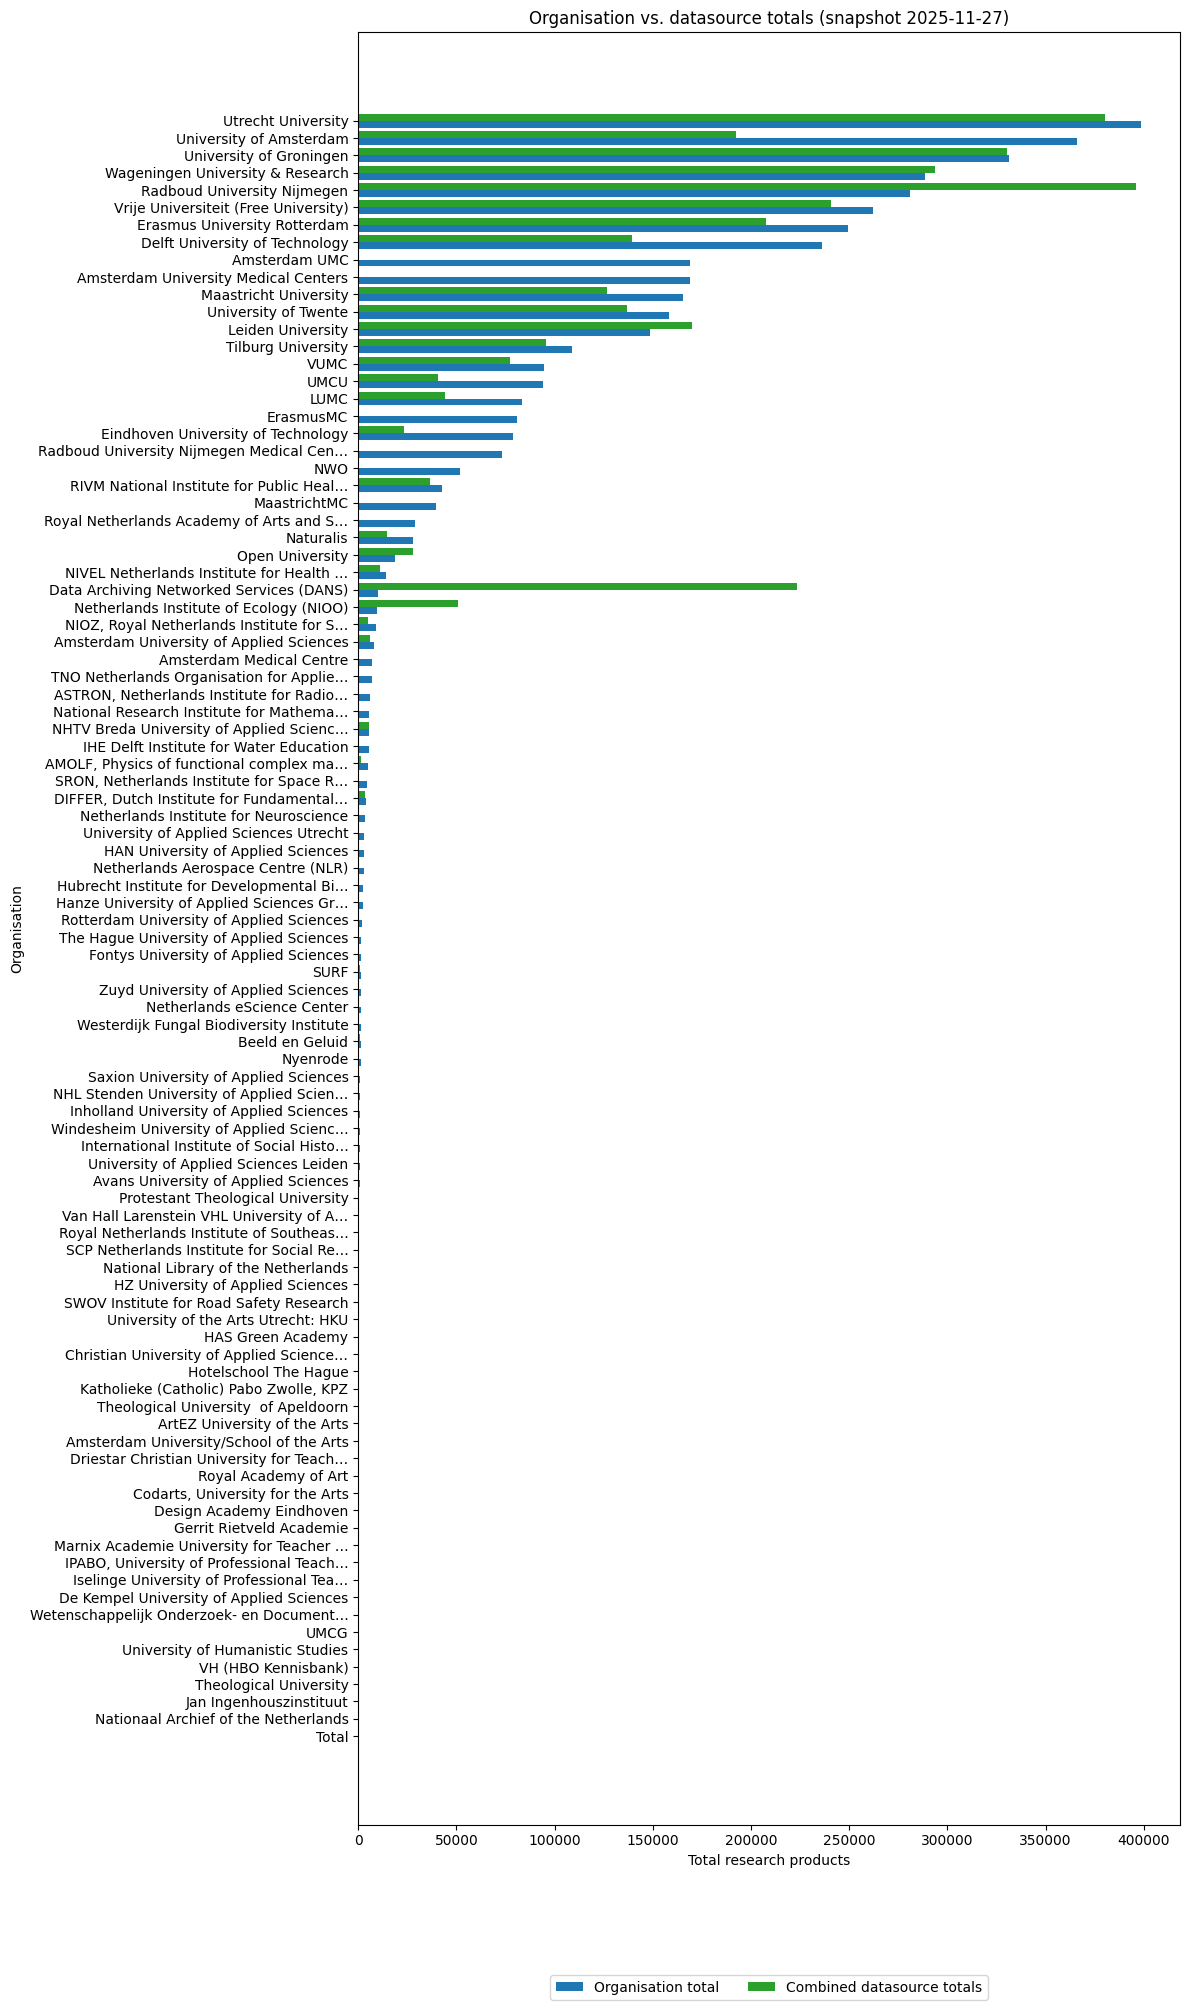

In [35]:
history_path = DATA_DIR / "nl_orgs_openaire_datasources_numFound_history.xlsx"
datasources_path = DATA_DIR / "nl_orgs_openaire_datasources.xlsx"
orgs_path = DATA_DIR / "nl_orgs_openaire.xlsx"
if not (history_path.exists() and datasources_path.exists() and orgs_path.exists()):
    print("One or more required files are missing. Please run Steps 3, 7, and 8 before this comparison.")
else:
    history_df = pd.read_excel(history_path)
    datasources_df = pd.read_excel(datasources_path)
    orgs_df = pd.read_excel(orgs_path)

    numeric_columns = [
        "Total Research Products",
        *PRODUCT_TYPE_LABELS.values(),
    ]
    for column in numeric_columns:
        if column in history_df.columns:
            history_df[column] = pd.to_numeric(history_df[column], errors="coerce")
        if column in orgs_df.columns:
            orgs_df[column] = pd.to_numeric(orgs_df[column], errors="coerce")

    history_df["date_retrieved"] = pd.to_datetime(history_df["date_retrieved"], errors="coerce")
    latest_date = history_df["date_retrieved"].max()
    datasource_latest = history_df[history_df["date_retrieved"] == latest_date].copy()

    if datasource_latest.empty:
        print("No datasource snapshot found for comparison.")
    else:
        datasource_latest["Total Research Products"] = datasource_latest["Total Research Products"].fillna(0)
        link_df = datasources_df[["OpenAIRE_DataSource_ID", "OpenAIRE_ORG_ID"]].copy()
        mapped = link_df.merge(
            datasource_latest[["OpenAIRE_DataSource_ID", "Total Research Products"]],
            on="OpenAIRE_DataSource_ID",
            how="left",
        )
        mapped["Total Research Products"] = mapped["Total Research Products"].fillna(0)
        datasource_by_org = mapped.groupby("OpenAIRE_ORG_ID")["Total Research Products"].sum()

        org_totals = orgs_df[["name", "OpenAIRE_ORG_ID", "Total Research Products"]].copy()
        org_totals["Total Research Products"] = org_totals["Total Research Products"].fillna(0)
        org_totals["Datasource totals"] = org_totals["OpenAIRE_ORG_ID"].map(datasource_by_org).fillna(0)

        if org_totals.empty:
            print("Organisation totals not available for comparison.")
        else:
            org_totals = org_totals.sort_values("Total Research Products", ascending=False)
            max_label_length = 40
            display_names = org_totals["name"].astype(str).apply(
                lambda text: text if len(text) <= max_label_length else text[: max_label_length - 1] + "…"
            )
            indices = range(len(org_totals))
            bar_height = 0.4

            fig, ax = plt.subplots(figsize=(12, 20))
            ax.barh(
                [i + bar_height / 2 for i in indices],
                org_totals["Total Research Products"],
                height=bar_height,
                color="#1f77b4",
                label="Organisation total",
            )
            ax.barh(
                [i - bar_height / 2 for i in indices],
                org_totals["Datasource totals"],
                height=bar_height,
                color="#2ca02c",
                label="Combined datasource totals",
            )

            ax.set_yticks(list(indices))
            ax.set_yticklabels(display_names)
            ax.set_xlabel("Total research products")
            ax.set_ylabel("Organisation")
            ax.set_title(
                f"Organisation vs. datasource totals (snapshot {latest_date.date()})"
            )
            ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.08), ncol=2)
            ax.invert_yaxis()
            fig.tight_layout()
            org_vs_ds_path = IMG_DIR / "org_vs_datasources.png"
            fig.savefig(org_vs_ds_path, dpi=200, bbox_inches="tight")
            print(f"Saved organisation vs datasource comparison chart to {org_vs_ds_path}")
            plt.show()


## 13. Organisation vs. individual datasource breakdown
Display each organisation alongside its own datasources for the latest snapshot.

Datasources with zero totals (excluded):
 - TRAILS (org: Utrecht University)
 - TRAILS (org: Utrecht University)
 - TRAILS (org: Utrecht University)
 - TRAILS (org: Utrecht University)
 - European Constitutional Law Review (org: University of Amsterdam)
 - Universiteit van Amsterdam (UvA) Institutional Repository UvA-DARE (org: University of Amsterdam)
 - ERLACS – European Review of Latin American and Caribbean Studies (org: University of Amsterdam)
 - University of Amsterdam / Amsterdam University of Applied Sciences figshare (org: University of Amsterdam)
 - University of Amsterdam / Amsterdam University of Applied Sciences figshare (org: University of Amsterdam)
 - Population Research Centre (org: University of Groningen)
 - Centre for Economic Research Working Papers (org: University of Groningen)
 - ARTS repository - University of Groningen (org: University of Groningen)
 - Documentserver Keur der Wetenschap (org: University of Groningen)
 - International Microvillus Inclusion Dis

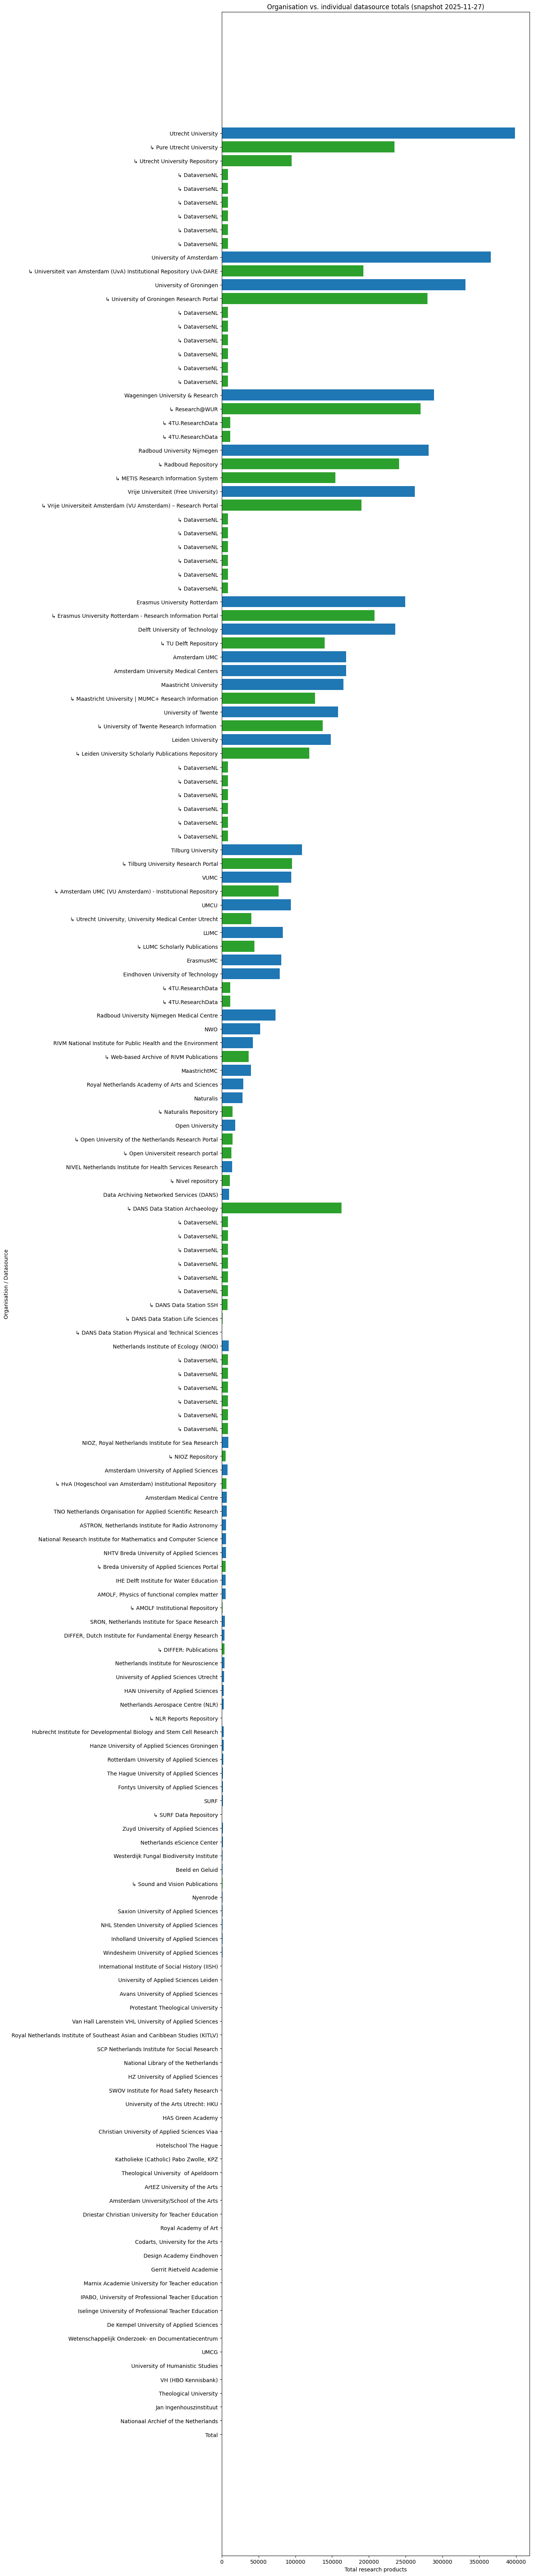

In [36]:
history_path = DATA_DIR / "nl_orgs_openaire_datasources_numFound_history.xlsx"
datasources_path = DATA_DIR / "nl_orgs_openaire_datasources.xlsx"
orgs_path = DATA_DIR / "nl_orgs_openaire.xlsx"
if not (history_path.exists() and datasources_path.exists() and orgs_path.exists()):
    print("One or more required files are missing. Run Steps 3, 7, and 8 first.")
else:
    history_df = pd.read_excel(history_path)
    datasources_df = pd.read_excel(datasources_path)
    orgs_df = pd.read_excel(orgs_path)

    numeric_columns = [
        "Total Research Products",
        *PRODUCT_TYPE_LABELS.values(),
    ]
    for column in numeric_columns:
        if column in history_df.columns:
            history_df[column] = pd.to_numeric(history_df[column], errors="coerce")
        if column in orgs_df.columns:
            orgs_df[column] = pd.to_numeric(orgs_df[column], errors="coerce")

    history_df["date_retrieved"] = pd.to_datetime(history_df["date_retrieved"], errors="coerce")
    latest_date = history_df["date_retrieved"].max()
    datasource_latest = history_df[history_df["date_retrieved"] == latest_date].copy()

    if datasource_latest.empty:
        print("No datasource snapshot found for breakdown chart.")
    else:
        datasource_latest["Total Research Products"] = datasource_latest["Total Research Products"].fillna(0)
        ds_with_org = datasources_df[[
            "OpenAIRE_DataSource_ID",
            "OpenAIRE_ORG_ID",
            "Name",
        ]].merge(
            datasource_latest[["OpenAIRE_DataSource_ID", "Total Research Products"]],
            on="OpenAIRE_DataSource_ID",
            how="left",
        )
        ds_with_org["Total Research Products"] = ds_with_org["Total Research Products"].fillna(0)
        orgs_df["Total Research Products"] = orgs_df["Total Research Products"].fillna(0)

        records = []
        zero_datasources: list[str] = []

        for _, org_row in orgs_df.sort_values("Total Research Products", ascending=False).iterrows():
            org_name = org_row.get("name", "Unknown organisation")
            org_id = org_row.get("OpenAIRE_ORG_ID")
            org_value = float(org_row.get("Total Research Products") or 0)
            records.append({"label": org_name, "value": org_value, "color": "#1f77b4"})

            org_ds = ds_with_org[ds_with_org["OpenAIRE_ORG_ID"] == org_id]
            if org_ds.empty:
                continue

            for _, ds_row in org_ds.sort_values("Total Research Products", ascending=False).iterrows():
                ds_value = float(ds_row.get("Total Research Products") or 0)
                ds_name = ds_row.get("Name") or ds_row.get("OpenAIRE_DataSource_ID")
                if ds_value <= 0:
                    zero_datasources.append(f"{ds_name} (org: {org_name})")
                    continue
                label = f"  ↳ {ds_name}"
                records.append({"label": label, "value": ds_value, "color": "#2ca02c"})

        if zero_datasources:
            print("Datasources with zero totals (excluded):")
            for entry in zero_datasources:
                print(f" - {entry}")

        if not records:
            print("No datapoints available for the breakdown chart.")
    
        else:
            values = [rec["value"] for rec in records]
            labels = [rec["label"] for rec in records]
            colors = [rec["color"] for rec in records]
            fig_height = max(6, 0.4 * len(records))
            fig, ax = plt.subplots(figsize=(14, fig_height))
            ax.barh(range(len(records)), values, color=colors)
            ax.set_yticks(range(len(records)))
            ax.set_yticklabels(labels)
            ax.set_xlabel("Total research products")
            ax.set_ylabel("Organisation / Datasource")
            ax.set_title(
                f"Organisation vs. individual datasource totals (snapshot {latest_date.date()})"
            )
            ax.invert_yaxis()
            fig.tight_layout()
            breakdown_path = IMG_DIR / "org_vs_datasource_breakdown.png"
            fig.savefig(breakdown_path, dpi=200, bbox_inches="tight")
            print(f"Saved organisation/datasource breakdown chart to {breakdown_path}")
            plt.show()


## 14. Download curated OAI endpoint list
Fetch the curated OAI-PMH spreadsheet and store it locally so downstream steps can reference the latest endpoint information.

In [37]:

CURATED_OAI_URL = (
    "https://docs.google.com/spreadsheets/d/e/"
    "2PACX-1vQwM24DIUWmqbjxaAy62w9w8gNpOMSg5sxmFro-OexCeMzIlyUJh5iVVsVxyrcLkQ/pub?output=xlsx"
)
curated_path = DATA_DIR / "curated_oai_endpoints.xlsx"

response = requests.get(CURATED_OAI_URL, timeout=30)
response.raise_for_status()
curated_path.write_bytes(response.content)
print(f"Saved curated OAI endpoints to {curated_path}")


Saved curated OAI endpoints to /home/mvanderfee3/data/ori-storage/dutch-sources/curated_oai_endpoints.xlsx


## 15. Merge curated endpoints into datasource export
Use the curated sheet to backfill `OAI-endpoint` values in the datasource workbook.

In [38]:

import ast

curated_path = DATA_DIR / "curated_oai_endpoints.xlsx"
datasources_path = DATA_DIR / "nl_orgs_openaire_datasources.xlsx"
output_path = DATA_DIR / "nl_orgs_openaire_datasources_with_endpoint.xlsx"

if not curated_path.exists():
    raise FileNotFoundError(
        f"Missing curated endpoint workbook: {curated_path}. Run step 14 first."
    )
if not datasources_path.exists():
    raise FileNotFoundError(
        f"Missing datasource export: {datasources_path}. Run step 7 first."
    )

datasources_df = pd.read_excel(datasources_path)
curated_df = pd.read_excel(curated_path)

def normalize_id(value):
    return str(value).strip() if pd.notna(value) else None

def clean_endpoint(value):
    if not isinstance(value, str):
        return None
    text = value.strip()
    if not text:
        return None
    if text.startswith("[") and text.endswith("]"):
        try:
            parsed = ast.literal_eval(text)
            if isinstance(parsed, (list, tuple)) and parsed:
                text = "" if parsed[0] is None else str(parsed[0])
            elif isinstance(parsed, str):
                text = parsed
            else:
                text = ""
        except Exception:
            text = text.strip("[]")
    text = text.strip().strip("\"'[]")
    if not text:
        return None
    if text.startswith("//"):
        text = f"https:{text}"
    elif not text.startswith(("http://", "https://")):
        text = f"https://{text}"
    return text

id_col = "OpenAIRE_DataSource_ID"
if id_col not in curated_df.columns:
    raise ValueError("Curated workbook missing OpenAIRE_DataSource_ID column")

endpoint_col = None
for candidate in ["oai_endpoint", "OAI_endpoint", "endpoint", "OAI-endpoint"]:
    if candidate in curated_df.columns:
        endpoint_col = candidate
        break
if endpoint_col is None:
    raise ValueError("Curated workbook missing an oai_endpoint column")

datasources_df[id_col] = datasources_df[id_col].apply(normalize_id)
curated_df[id_col] = curated_df[id_col].apply(normalize_id)
curated_df[endpoint_col] = curated_df[endpoint_col].apply(clean_endpoint)

endpoint_map = (
    curated_df.dropna(subset=[id_col, endpoint_col])
              .drop_duplicates(subset=[id_col], keep="first")
              .set_index(id_col)[endpoint_col]
              .to_dict()
)

ensure_object = lambda s: s.astype("object") if s.dtype != "object" else s
if "OAI-endpoint" not in datasources_df.columns:
    datasources_df["OAI-endpoint"] = pd.Series(pd.NA, index=datasources_df.index, dtype="object")
datasources_df["OAI-endpoint"] = ensure_object(datasources_df["OAI-endpoint"])

mapped = datasources_df[id_col].map(endpoint_map)
updated_mask = mapped.notna()
datasources_df.loc[updated_mask, "OAI-endpoint"] = mapped[updated_mask]

debug_examples = datasources_df.loc[updated_mask, [id_col, "OAI-endpoint"]].head(10)
print("Sample endpoint mappings:")
if debug_examples.empty:
    print("  No endpoints were updated.")
else:
    print(debug_examples.to_string(index=False))

datasources_df.to_excel(output_path, index=False)
print(
    f"Updated {updated_mask.sum()} datasource endpoints using curated sheet; saved to {output_path}"
)


Sample endpoint mappings:
                        OpenAIRE_DataSource_ID                                             OAI-endpoint
re3data_____::c4493890b3fefddfe9408389ff121d43            https://phys-techsciences.datastations.nl/oai
opendoar____::451ee190d0efc1f77c8bcc7238979ac1                          https://ssh.datastations.nl/oai
opendoar____::bc8741c4e92bbbca75ab9fe51f54664a                  https://archaeology.datastations.nl/oai
re3data_____::c4493890b3fefddfe9408389ff121d43            https://phys-techsciences.datastations.nl/oai
opendoar____::7792b558ca0c76d24d695582021ac501                 https://lifesciences.datastations.nl/oai
re3data_____::2559b4dd27ae4bc6c7f3727ec863444f                                 https://dataverse.nl/oai
re3data_____::2559b4dd27ae4bc6c7f3727ec863444f                                 https://dataverse.nl/oai
opendoar____::a8fbbd3b11424ce032ba813493d95ad7 https://scholarlypublications.universiteitleiden.nl/oai2
opendoar____::77b88288ebae7b17b7c8610a

## 16. Probe OAI-PMH endpoints and capture supported formats
Validate every datasource OAI endpoint against the OAI-PMH specification and OpenAIRE/Dutch profile requirements, recording which mandatory metadata prefixes are actually exposed.

In [39]:

import xml.etree.ElementTree as ET
from urllib.parse import urlparse

datasources_with_endpoint_path = DATA_DIR / "nl_orgs_openaire_datasources_with_endpoint.xlsx"
metrics_output_path = DATA_DIR / "nl_orgs_openaire_datasources_with_endpoint_metrics.xlsx"

if not datasources_with_endpoint_path.exists():
    raise FileNotFoundError(
        f"Missing endpoint-enriched datasources file: {datasources_with_endpoint_path}. Run step 15 first."
    )

metrics_df = pd.read_excel(datasources_with_endpoint_path)

if "OpenAIRE_DataSource_ID" not in metrics_df.columns:
    raise ValueError("Input file missing OpenAIRE_DataSource_ID column.")

detection_columns = {
    "detected_support_nl_didl": {"nl_didl"},
    "detected_support_oai_dc": {"oai_dc"},
    "detected_support_oai_openaire": {"oai_openaire"},
    "detected_support_rioxx": {"rioxx", "rioxxv2"},
    "detected_support_oai_cerif_openaire": {"cerif_openaire", "oai_cerif_openaire"},
    "detected_support_openaire_data": {"oai_datacite", "datacite", "oai_openaire_data", "openaire_data"},
}

for column in detection_columns.keys():
    metrics_df[column] = False

metrics_df["oai_status"] = "not_tested"
metrics_df["oai_error"] = pd.NA
metrics_df["metadata_prefixes_detected"] = pd.NA
metrics_df["oai_tested_at_utc"] = pd.NA

def normalise_endpoint(url: str) -> list[str]:
    if not isinstance(url, str):
        return []
    raw = url.strip()
    if not raw:
        return []
    candidates = []
    parsed = urlparse(raw)
    if parsed.scheme:
        candidates.append(raw)
        if parsed.scheme == "http":
            candidates.append(raw.replace("http://", "https://", 1))
    else:
        candidates.append(f"https://{raw}")
        candidates.append(f"http://{raw}")
    seen: list[str] = []
    for cand in candidates:
        if cand not in seen:
            seen.append(cand)
    return seen

def build_oai_url(base: str, verb: str = "ListMetadataFormats") -> str:
    if base.endswith("?") or base.endswith("&"):
        return f"{base}verb={verb}"
    return f"{base}&verb={verb}" if "?" in base else f"{base}?verb={verb}"

def parse_metadata_formats(xml_bytes: bytes) -> tuple[list[str], str | None]:
    try:
        root = ET.fromstring(xml_bytes)
    except ET.ParseError as exc:
        return [], f"XML parse error: {exc}"
    ns = {"oai": "http://www.openarchives.org/OAI/2.0/"}
    prefixes = [
        (el.text or "").strip().lower()
        for el in root.findall(".//oai:metadataPrefix", namespaces=ns)
        if (el.text or "").strip()
    ]
    if prefixes:
        return prefixes, None
    errors = root.findall(".//oai:error", namespaces=ns)
    if errors:
        messages = [
            f"{err.get('code', 'error')}: {(err.text or '').strip()}" for err in errors
        ]
        return [], "; ".join(messages)
    return [], "No metadataPrefix elements returned"

def test_endpoint(endpoint: str) -> dict[str, Any]:
    result = {
        "oai_status": "missing_endpoint" if not endpoint else "error",
        "oai_error": None,
        "metadata_prefixes_detected": None,
    }
    prefix_flags = {column: False for column in detection_columns.keys()}
    if not endpoint:
        result.update(prefix_flags)
        return result

    prefixes: list[str] = []
    errors: list[str] = []
    for candidate in normalise_endpoint(endpoint):
        url = build_oai_url(candidate)
        try:
            resp = requests.get(url, timeout=25, headers={"User-Agent": API_USER_AGENT})
            resp.raise_for_status()
        except Exception as exc:
            errors.append(f"{candidate}: {exc}")
            continue
        prefixes, error = parse_metadata_formats(resp.content)
        if prefixes:
            result["oai_status"] = "ok"
            errors = []
            break
        if error:
            errors.append(f"{candidate}: {error}")

    if prefixes:
        detected_str = ", ".join(sorted(set(prefixes)))
        result["metadata_prefixes_detected"] = detected_str
        for column, required in detection_columns.items():
            prefix_flags[column] = any(prefix in required for prefix in prefixes)
    else:
        result["oai_error"] = "; ".join(errors) if errors else "Unknown error"

    result.update(prefix_flags)
    return result

with ThreadPoolExecutor(max_workers=6) as executor:
    futures = {
        executor.submit(test_endpoint, row.get("OAI-endpoint")): idx
        for idx, row in metrics_df.iterrows()
    }
    for future in tqdm(
        as_completed(futures),
        total=len(futures),
        desc="Testing OAI endpoints",
        unit="datasource",
    ):
        idx = futures[future]
        outcome = future.result()
        for key, value in outcome.items():
            metrics_df.at[idx, key] = value
        metrics_df.at[idx, "oai_tested_at_utc"] = pd.Timestamp.utcnow().isoformat()

metrics_df.to_excel(metrics_output_path, index=False)
print(
    f"Saved OAI endpoint diagnostics for {len(metrics_df)} datasources to {metrics_output_path}"
)


Testing OAI endpoints:   0%|          | 0/170 [00:00<?, ?datasource/s]

Saved OAI endpoint diagnostics for 170 datasources to /home/mvanderfee3/data/ori-storage/dutch-sources/nl_orgs_openaire_datasources_with_endpoint_metrics.xlsx


## 17. Visualise OAI endpoint coverage
Summaries of endpoint availability, test outcomes, and required metadata-format support.

,metric,count
0,Endpoints available,65
1,OAI test passed,59
2,OAI test failed,111
3,Indexed by OpenAIRE,77
4,CRIS endpoints w/ CERIF,14
5,Literature endpoints w/ OpenAIRE,10
6,Data endpoints w/ OpenAIRE data,10
7,Endpoints w/ NL DIDL,34
8,Endpoints w/ RIOXX,0


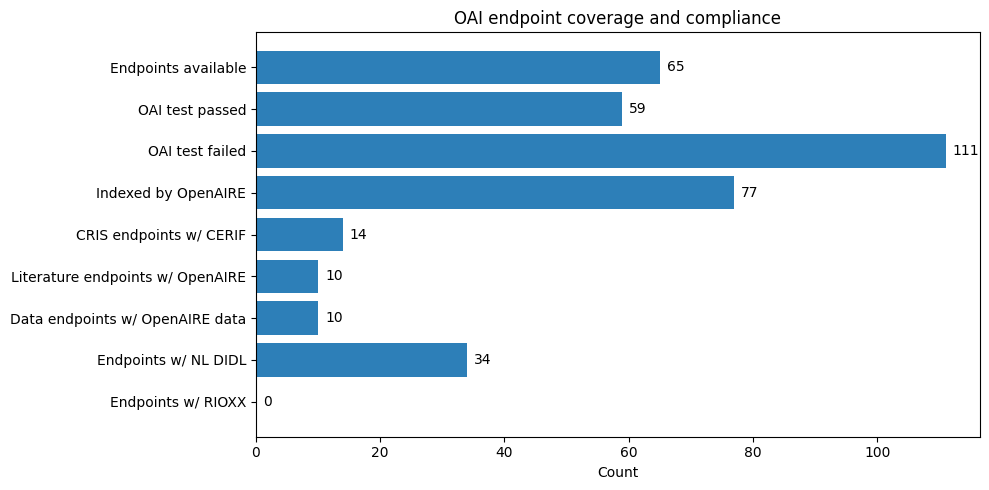

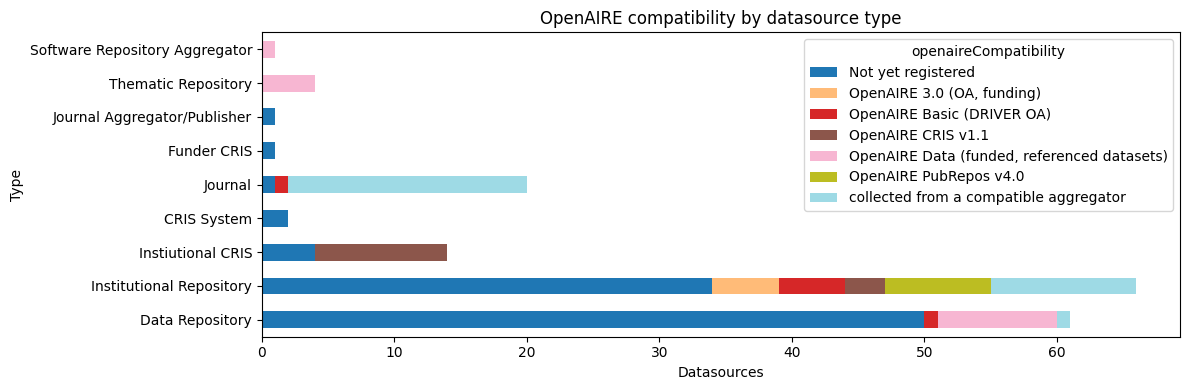

Saved charts to img/oai_endpoint_summary.png and img/oai_openaire_compatibility_by_type.png


In [40]:

metrics_path = DATA_DIR / "nl_orgs_openaire_datasources_with_endpoint_metrics.xlsx"
if not metrics_path.exists():
    raise FileNotFoundError(
        f"Missing OAI diagnostics: {metrics_path}. Run step 16 first."
    )

metrics_df = pd.read_excel(metrics_path)

def is_blank(series: pd.Series) -> pd.Series:
    text = series.astype(str).str.strip().str.lower()
    blank_tokens = {"", "nan", "<na>", "none", "null"}
    return series.isna() | text.isin(blank_tokens)

total_endpoints = (~is_blank(metrics_df["OAI-endpoint"])).sum()
passed = (metrics_df["oai_status"] == "ok").sum()
failed = (metrics_df["oai_status"] == "error").sum()

def is_indexed(value) -> bool:
    if not isinstance(value, str):
        return False
    text = value.strip().lower()
    if not text or "not yet" in text:
        return False
    keywords = ["openaire", "collected from a compatible aggregator"]
    return any(keyword in text for keyword in keywords)

indexed = metrics_df["openaireCompatibility"].apply(is_indexed).sum()

type_series = metrics_df["Type"].fillna("")
cris_mask = type_series.str.contains("cris", case=False, na=False)
literature_mask = type_series.str.contains("literature|institutional", case=False, na=False)
data_mask = type_series.str.contains("data repository", case=False, na=False)

cris_cerif = (
    cris_mask & metrics_df.get("detected_support_oai_cerif_openaire", False).astype(bool)
).sum()
literature_openaire = (
    literature_mask & metrics_df.get("detected_support_oai_openaire", False).astype(bool)
).sum()
data_openaire = (
    data_mask & metrics_df.get("detected_support_openaire_data", False).astype(bool)
).sum()

nl_didl = metrics_df.get("detected_support_nl_didl", False).astype(bool).sum()
rioxx = metrics_df.get("detected_support_rioxx", False).astype(bool).sum()

summary = pd.DataFrame(
    {
        "metric": [
            "Endpoints available",
            "OAI test passed",
            "OAI test failed",
            "Indexed by OpenAIRE",
            "CRIS endpoints w/ CERIF",
            "Literature endpoints w/ OpenAIRE",
            "Data endpoints w/ OpenAIRE data",
            "Endpoints w/ NL DIDL",
            "Endpoints w/ RIOXX",
        ],
        "count": [
            total_endpoints,
            passed,
            failed,
            indexed,
            cris_cerif,
            literature_openaire,
            data_openaire,
            nl_didl,
            rioxx,
        ],
    }
)

display(summary)

summary_chart_path = IMG_DIR / "oai_endpoint_summary.png"

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(summary["metric"], summary["count"], color="#2d7fb8")
ax.set_xlabel("Count")
ax.set_title("OAI endpoint coverage and compliance")
ax.invert_yaxis()
for i, value in enumerate(summary["count"]):
    ax.text(value + max(summary["count"]) * 0.01, i, f"{value}", va="center")
plt.tight_layout()
plt.savefig(summary_chart_path, dpi=150)
plt.show()

compat_df = metrics_df.copy()
compat_df["Type"] = compat_df["Type"].fillna("Unknown")
compat_df["openaireCompatibility"] = compat_df["openaireCompatibility"].fillna("Unknown")

compat_counts = (
    compat_df.groupby(["Type", "openaireCompatibility"], dropna=False)
             .size()
             .reset_index(name="count")
)
compat_pivot = compat_counts.pivot(
    index="Type", columns="openaireCompatibility", values="count"
).fillna(0)
compat_pivot = compat_pivot.sort_values(by=compat_pivot.columns.tolist(), ascending=False)

compat_chart_path = IMG_DIR / "oai_openaire_compatibility_by_type.png"

fig2, ax2 = plt.subplots(figsize=(12, max(4, 0.4 * len(compat_pivot))))
compat_pivot.plot(kind="barh", stacked=True, ax=ax2, colormap="tab20")
ax2.set_xlabel("Datasources")
ax2.set_ylabel("Type")
ax2.set_title("OpenAIRE compatibility by datasource type")
ax2.legend(title="openaireCompatibility", bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.savefig(compat_chart_path, dpi=150)
plt.show()

print(
    f"Saved charts to {summary_chart_path} and {compat_chart_path}"
)


## 18. Interactive datasource dashboard

This dashboard will help to review datasource health, latest volumes, and metadata compliance in a single view.

Filter by using the drop down menus or by selecting bar chart segments or heatmap cells. 

In [41]:
from IPython.display import HTML, display

OPENAIRE_ORG_URL = "https://explore.openaire.eu/search/organization?organizationId="
OPENAIRE_DATASOURCE_URL = "https://explore.openaire.eu/search/dataprovider?datasourceId="

orgs_path = DATA_DIR / "nl_orgs_openaire.xlsx"
history_path = DATA_DIR / "nl_orgs_openaire_datasources_numFound_history.xlsx"
metrics_path = DATA_DIR / "nl_orgs_openaire_datasources_with_endpoint_metrics.xlsx"

print(f"Loading organisations from {orgs_path} ...")
orgs_df = pd.read_excel(orgs_path)[["OpenAIRE_ORG_ID", "name"]].rename(columns={"name": "Organisation"})
print(f"Loaded {len(orgs_df)} organisation rows")

print(f"Loading datasource history from {history_path} ...")
history_df = pd.read_excel(history_path)
print(f"Loaded history with {len(history_df)} rows")

print(f"Loading endpoint metrics from {metrics_path} ...")
metrics_df = pd.read_excel(metrics_path)
print(f"Loaded metrics with {len(metrics_df)} rows")

if history_df.empty:
    raise ValueError("History workbook is empty; run the snapshot steps first.")

latest_date = history_df["date_retrieved"].max()
print(f"Latest snapshot date detected: {latest_date}")
latest_snapshot = history_df[history_df["date_retrieved"] == latest_date].copy()
print(f"Latest snapshot records: {len(latest_snapshot)}")

value_cols = [
    "Total Research Products",
    "Publications",
    "Research data",
    "Research software",
    "Other research products",
]

latest_snapshot = latest_snapshot[["OpenAIRE_DataSource_ID", *value_cols, "date_retrieved"]]

print("Merging metrics with snapshot and organisations ...")
dashboard_df = (
    metrics_df.merge(latest_snapshot, on="OpenAIRE_DataSource_ID", how="left", suffixes=("", "_latest"))
              .merge(orgs_df, on="OpenAIRE_ORG_ID", how="left")
)
print(f"Dashboard dataframe size: {dashboard_df.shape}")

bool_cols = [
    "detected_support_oai_cerif_openaire",
    "detected_support_oai_openaire",
    "detected_support_openaire_data",
    "detected_support_nl_didl",
    "detected_support_rioxx",
]

dashboard_df[bool_cols] = dashboard_df[bool_cols].fillna(False)
dashboard_df["Organisation Name"] = dashboard_df["Organisation"].fillna("Unknown organisation")
dashboard_df["Datasource Name"] = dashboard_df["Name"].fillna("Unknown datasource")
dashboard_df["OpenAIRE Compatibility"] = dashboard_df["openaireCompatibility"].fillna("Not specified")
dashboard_df["Type"] = dashboard_df["Type"].fillna("Unknown")
dashboard_df["oai_status"] = dashboard_df["oai_status"].fillna("Unknown")
dashboard_df["has_endpoint"] = dashboard_df["OAI-endpoint"].astype(str).str.strip().ne("")

dashboard_df["Latest Snapshot Date"] = latest_date
org_totals = (
    dashboard_df.groupby("Organisation Name")["Total Research Products"]
    .sum(min_count=1)
    .fillna(0)
)
dashboard_df["Total Research Products by Affiliation"] = (
    dashboard_df["Organisation Name"].map(org_totals).fillna(0)
)

dashboard_export_path = DATA_DIR / "nl_orgs_dashboard_data.xlsx"
export_columns = [
    "Organisation Name",
    "Organisation",
    "OpenAIRE_ORG_ID",
    "Datasource Name",
    "OpenAIRE_DataSource_ID",
    "OpenAIRE Compatibility",
    "Type",
    "oai_status",
    "OAI-endpoint",
    "metadata_prefixes_detected",
    "Total Research Products",
    "Publications",
    "Research data",
    "Research software",
    "Other research products",
    "detected_support_oai_cerif_openaire",
    "detected_support_oai_openaire",
    "detected_support_openaire_data",
    "detected_support_nl_didl",
    "detected_support_rioxx",
    "has_endpoint",
    "Latest Snapshot Date",
    "Total Research Products by Affiliation",
]

missing_cols = [col for col in export_columns if col not in dashboard_df.columns]
if missing_cols:
    raise KeyError(f"Missing expected columns for dashboard export: {missing_cols}")

print(f"Writing dashboard export to {dashboard_export_path} ...")
dashboard_df[export_columns].to_excel(dashboard_export_path, index=False)
print("Dashboard export complete.")

display(
    HTML(
        """
        <p>
            Dashboard data exported to <code>data/nl_orgs_dashboard_data.xlsx</code>.<br>
            Launch the Streamlit dashboard via <code>streamlit run streamlit_app.py</code>.<br>
            Ensure this notebook cell is rerun whenever new snapshots are captured so the app reflects the latest data.
        </p>
        """
    )
)


Loading organisations from /home/mvanderfee3/data/ori-storage/dutch-sources/nl_orgs_openaire.xlsx ...
Loaded 94 organisation rows
Loading datasource history from /home/mvanderfee3/data/ori-storage/dutch-sources/nl_orgs_openaire_datasources_numFound_history.xlsx ...
Loaded history with 170 rows
Loading endpoint metrics from /home/mvanderfee3/data/ori-storage/dutch-sources/nl_orgs_openaire_datasources_with_endpoint_metrics.xlsx ...
Loaded metrics with 170 rows
Latest snapshot date detected: 2025-11-27
Latest snapshot records: 170
Merging metrics with snapshot and organisations ...
Dashboard dataframe size: (224, 31)
Writing dashboard export to /home/mvanderfee3/data/ori-storage/dutch-sources/nl_orgs_dashboard_data.xlsx ...
Dashboard export complete.
